## GroupBy: Customer Classification Model

### Drive Set Up


In [ ]:
#Mount the RAW session level data: 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/GroupBy/')

In [ ]:
!pip install -U yellowbrick

     |████████████████████████████████| 271 kB 15.7 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


### Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

### Load Data

In [ ]:
#load the 'eCommerce Events History in Cosmetics Shop' data set
json_data = pd.read_csv('df_json_cluster.csv')

#copy for other use
original_data = json_data

### Explore Data

### Data Pre-processing

##### Address Missing Values

In [ ]:
# re-check address missing values
null_columns= json_data.columns[json_data.isnull().any()]
json_data[null_columns].isnull().sum()

product_name              216
listLocation           140737
listPosition           140737
hits.totalitems       1539181
hits.totalquantity    1539181
totalAddToCartQty      625984
uniqueSearches          48522
queriesSearched        259452
uniqueRefinements     1454237
uniqueNavigations     1454237
totalOrderQty         1061582
dtype: int64

In [ ]:
#remove values with missing rows
json_data = json_data.dropna(subset=['product_name'])

In [ ]:
# columns with misisng values that can be filled in with 0
cols_fill_0 = ['totalAddToCartQty','totalOrderQty']

# replace missing values with 0
json_data[cols_fill_0] = json_data[cols_fill_0].fillna(0)

In [ ]:
#drop columns with siginifican missign data 
json_data = json_data.drop(columns=['queriesSearched', 'uniqueRefinements','uniqueNavigations', 'hits.totalitems','hits.totalquantity','listLocation','listPosition','uniqueSearches'])

In [ ]:
# re-check address missing values
null_columns= json_data.columns[json_data.isnull().any()]
json_data[null_columns].isnull().sum()

Series([], dtype: float64)

##### Convert Non-Numeric Columns

In [ ]:
#create pd.series for customer visitor id for later use
original_cust_id = original_data['customerVisitorId']

In [ ]:
#filter for non-numeric columns
df_json_numeric = json_data.select_dtypes(exclude=['int64','float64'])

In [ ]:
non_numeric_cols= ['product_id', 'product_name', 'product_brand','customerId', 'customerArea', 'customerVisitorId', 'customerLoginId',
       'customerSessionId']

In [ ]:
#import ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

# function apply encoder
def ord_encode(data):
	oe = OrdinalEncoder()
	oe.fit(data)
	data_encoded = oe.transform(data)
	return data_encoded

In [ ]:
json_data[non_numeric_cols] = ord_encode(json_data[non_numeric_cols])

In [ ]:
test_non_numeric = json_data.select_dtypes(exclude=['int64','float64'])
test_non_numeric.columns

Index([], dtype='object')

In [ ]:
#add total session
json_data['total_session'] = json_data.groupby(['customerVisitorId'])['customerSessionNumber'].transform('sum')

### KMeans Clustering: User Behavior

##### Dimensionality Reduction

In [ ]:
pca=PCA(n_components=48)
data_pca =pca.fit_transform(json_data)
print(data_pca.shape)

(1578593, 48)


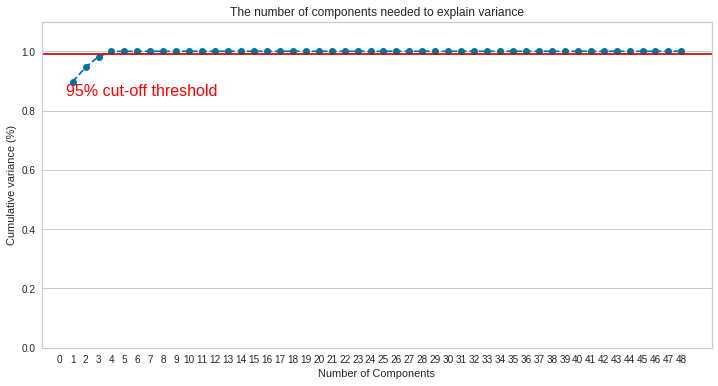

In [ ]:

% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 49, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 49, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca=PCA(n_components=5)
data_pca =pca.fit_transform(json_data)
print(data_pca.shape)

(1578593, 5)


##### Elbow Method: Optimal Number of Clusters

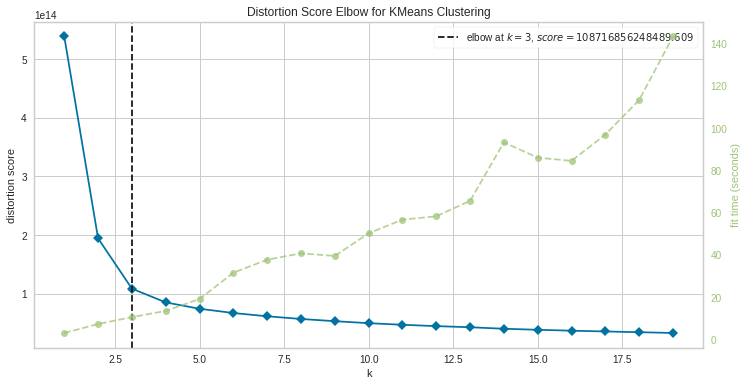

In [ ]:
#initiate kmeans model
model = KMeans()
# fit the visualizer to the reduced features data
visualizer = KElbowVisualizer(model, k=(1,20))
# fit the data to the visualizer
visualizer.fit(data_pca) 
visualizer.show()

##### KMeans with Optimal Clusters

In [ ]:
# create dataframe to store kmeans results/clusters
data_clusters = json_data.copy() 

In [ ]:
# optimal number of clusters from Elbow method
n = 3
# Instantiate the clustering model
clusters = KMeans(n_clusters = n)
# Assign the points in the reduced dataset to clusters
json_data['Cluster_ID']  = clusters.fit_predict(data_pca)
# print unique classes
#print(np.unique(C_vals))

In [ ]:
#save to csv
json_data.to_csv('data_clusters.csv', index=False)

In [ ]:
#load data
data_clusters = pd.read_csv('data_clusters.csv')

### Cluster Visualization

In [ ]:
data_clusters.columns

Index(['product_id', 'product_name', 'product_price', 'product_brand',
       'hitSequence', 'first_session_event', 'last_session_event',
       'total_price_cart', 'customerId', 'customerArea', 'customerVisitorId',
       'customerLoginId', 'customerSessionId', 'customerSessionNumber',
       'totals_events', 'newSession', 'bounce', 'totalSearches',
       'totalNavigations', 'totalRefinements', 'totalViewProducts',
       'totalViewProductRevenue', 'totalNullSearches', 'uniqueViewProducts',
       'totalAddToCarts', 'totalAddToCartQty', 'totalAddToCartRevenue',
       'uniqueAddToCarts', 'totalOrders', 'totalOrderQty', 'totalOrderRevenue',
       'uniqueOrders', 'event_type_cart', 'event_type_purchase',
       'hits.eventType.category_search', 'event_type_view', 'timeOnSite',
       'event_year', 'event_month', 'event_day_of_week', 'event_day_of_month',
       'event_day_of_year', 'event_hour', 'event_minute', 'event_second',
       'event_micorsecond', 'weekend', 'holiday', 'total_s

In [ ]:
cols_plot = ['product_id', 'product_name', 'product_price', 'product_brand',
'hitSequence', 'first_session_event', 'last_session_event',
'total_price_cart',  'customerArea', 'customerVisitorId', 'customerSessionId', 'customerSessionNumber',
'totals_events', 'newSession', 'totalSearches','totalViewProducts',
'totalAddToCarts', 'totalAddToCartRevenue','totalOrders', 'totalOrderRevenue',
'uniqueOrders', 'event_type_cart', 'event_type_purchase', 'event_type_view', 'timeOnSite',
'weekend', 'holiday', 'total_session',
'Cluster_ID']

In [ ]:
df_plot  = data_clusters[cols_plot]

In [ ]:
# Plot results
import plotly.express as px
polar=df_plot.groupby('Cluster_ID').mean().reset_index()
polar=pd.melt(polar,id_vars=['Cluster_ID'])
fig4 = px.line_polar(polar, r="value", theta="variable", color='Cluster_ID', line_close=True, height=600, width=1000)
fig4.show()

##### Cluster Analysis: Size and Purchase Ratio

In [ ]:
column_values = data_clusters['Cluster_ID']

In [ ]:
# get all the values in the 'ClusterID' column
column_values = data_clusters['Cluster_ID']
# complute the unique cluster ID values
unique_values_a = pd.unique(column_values)
# sort the unique cluster ID values
unique_values =  np.sort(unique_values_a)
print(unique_values)

[0 1 2]


In [ ]:
#create empty dataframe to store cluster stats (ie: purchase percentate and representation percentage)
temp_df_clusters = pd.DataFrame(columns = ['Cluster_ID', 'Representation_Percentage','Purchase_Percentage'])

# get total purchase
total_purchase = len(data_clusters[data_clusters['event_type_purchase'] == 1].index)

# loop through the clusters, percentages, and append dataframe
for index, item in enumerate(unique_values):
    temp_df = data_clusters.loc[data_clusters['Cluster_ID'] == item]
    locations = temp_df.shape[0]
    purchase = temp_df.loc[temp_df['event_type_purchase'] == 1].shape[0]
    representation_percentage = round((locations / data_clusters.shape[0]) * 100, 2)
    purchase_percentage = round((purchase/locations) * 100, 2)
    temp_df_clusters = temp_df_clusters.append({'Cluster_ID': item,  'Representation_Percentage':representation_percentage,
                                     'Purchase_Percentage':  purchase_percentage}, ignore_index= True)

df_cluster_stats = temp_df_clusters
overall_purchase_ratio = round(total_purchase/data_clusters.shape[0],2)

print('Overall Purchase Ratio: ' +  str(overall_purchase_ratio))
df_cluster_stats

Overall Purchase Ratio: 0.01


,Cluster_ID,Representation_Percentage,Purchase_Percentage
0,0.0,32.41,0.96
1,1.0,52.37,1.32
2,2.0,15.22,0.68


### Determine Classification

In [ ]:
drop_cols_3 = ['customerArea', 'product_id', 'product_name','first_session_event', 'last_session_event',
             'customerId', 'customerArea', 'customerVisitorId','customerLoginId', 'customerSessionId', 'hits.eventType.category_search',
             'event_year', 'event_month', 'event_day_of_week', 'event_day_of_month','event_day_of_year', 'event_hour', 'event_minute', 'event_second','event_micorsecond', 'weekend', 'holiday',
             'newSession','totalNavigations', 'totalRefinements', 'totalViewProductRevenue', 'totalNullSearches', 'hitSequence', ]

In [ ]:
json_piv_3 = data_clusters.drop(columns=drop_cols_3)

In [ ]:
pivot_3 = json_piv_3.pivot_table(json_piv_3, columns = ['Cluster_ID'])

In [ ]:
pivot_3

Cluster_ID,0,1,2
bounce,0.068864,0.040744,0.139255
customerSessionNumber,1.000000,1.000000,1.000000
event_type_cart,0.014090,0.014192,0.012691
event_type_purchase,0.009635,0.013196,0.006837
event_type_view,0.065375,0.050412,0.108147
product_brand,881.806920,887.492315,865.062034
product_price,13.841599,13.951103,13.981326
timeOnSite,1874.490165,2310.780088,1116.076893
totalAddToCartQty,4.423832,4.308630,2.203956
totalAddToCartRevenue,37.505046,33.959967,17.175955


In [ ]:
cl0 = data_clusters[data_clusters['Cluster_ID']==0].drop_duplicates(subset='customerVisitorId', keep="last")
session_avg0 = cl0['total_session'].sum()/len(cl0['customerVisitorId'].unique()) 
session_avg0

31.855088702147526

In [ ]:
cl1 = data_clusters[data_clusters['Cluster_ID']==1].drop_duplicates(subset='customerVisitorId', keep="last")
session_avg1 = cl1['total_session'].sum()/len(cl1['customerVisitorId'].unique())
session_avg1

71.0741791301358

In [ ]:
cl2 = data_clusters[data_clusters['Cluster_ID']==2].drop_duplicates(subset='customerVisitorId', keep="last")
session_avg2 = cl2['total_session'].sum()/len(cl2['customerVisitorId'].unique())
session_avg2

14.244922129448689

# Final Flask Dataset

In [ ]:
# add original customer visitor back to data set
data_clusters['CustomerId'] = original_cust_id

In [ ]:
#create dictionary with Customer Class and Cluster_ID
class_cluster_dict = {0:'Intentional Shopper', 1 : 'Educated Perusing Shopper', 2:'New Shopper'}

#execute dictionary mapping reference
data_clusters ['Class'] = np.nan
data_clusters.Class= data_clusters.Class.fillna(data_clusters.Cluster_ID.map(class_cluster_dict))

In [ ]:
# Load final dataset 
flask_dataset = pd.read_csv('Copy of groupby_data_flask_final.csv')
flask_dataset['Class'] = np.nan

In [ ]:
#preview dataset
flask_dataset.head()

,CustomerId,ProductId,ProductName,purchase_probability,event_type_purchase,Class
0,cki6s4tr200013bdpkaye9mdn,BR013,nutritional yeast seasoning,0.999981,0,NaN
1,cki6rrijb000125c5cdol7ahd,DRB004,pure castile bar soap peppermint,0.999977,0,NaN
2,cki6uboil00013he8jwwj434w,SUS022,100% daily value multi-vitamin,0.999969,0,NaN
3,cki6vcrm500013vcysh1hk38z,NLS002,natural elderberry concentrate blend,0.999994,0,NaN
4,cki6vggk900013xe68nl4dao3,MOM002,organic hair remover with tea tree refill jar,0.999995,0,NaN


In [ ]:
#create dataframe with unique rows defined as customer_visitor id and customer classification
df_clusters_unique = data_clusters.drop_duplicates(subset='customerVisitorId', keep="first")

#create dictionary from dataframe
class_dict = pd.Series(df_clusters_unique.Class.values, index= df_clusters_unique.CustomerId).to_dict()

#execute dictionary mapping reference
flask_dataset.Class= flask_dataset.Class.fillna(flask_dataset.CustomerId.map(class_dict))

In [ ]:
flask_dataset.Class.unique()

array(['Intentional Shopper', 'Educated Perusing Shopper', 'New Shopper',
       nan], dtype=object)

In [ ]:
#final data check
flask_dataset.tail()

,CustomerId,ProductId,ProductName,purchase_probability,event_type_purchase,Class
1578804,cki7kjoqd00013ge7o1kymd4y,NCR001,20 ct,6.535078e-07,1,New Shopper
1578805,cki14ghhf00013hcy0lh3chtq,XL059,16 fl oz liquid,1.455247e-04,1,Intentional Shopper
1578806,cki4udb7y00012c9tudpao7c8,SW035,800 mcg 250 caps,2.626375e-06,1,NaN
1578807,cki6aun0n00013e9pficr65sf,MGF035,60 tabs,3.057858e-06,1,Educated Perusing Shopper
1578808,cki6aun0n00013e9pficr65sf,GLF286,30 mg 30 sgels,6.232615e-07,1,Educated Perusing Shopper


In [ ]:
new_shopper_filter  = flask_dataset[flask_dataset['Class'] == 'New Shopper']
df_new_shopper = new_shopper_filter[new_shopper_filter['purchase_probability'] < 0.4]
df_new_shopper.head()

,CustomerId,ProductId,ProductName,purchase_probability,event_type_purchase,Class
2867,ckhzaa5ju00013m8v3oiunar0,NWF302,dmg,0.120983,0,New Shopper
2868,ckhzaa5ju00013m8v3oiunar0,ET034,dmg-b15 complex,0.120757,0,New Shopper
3561,cki7g16vs0001368ehnk1aefn,SW1016,oregano oil 10:1 extract,0.161240,0,New Shopper
3562,cki7g16vs0001368ehnk1aefn,SW854,n-acetyl cysteine,0.161147,0,New Shopper
3563,cki7g16vs0001368ehnk1aefn,SWU305,triple strength melatonin,0.161174,0,New Shopper


In [ ]:
intentional_shopper = flask_dataset[flask_dataset['Class'] == 'New Shopper']
df_new_shopper = intentional_shopper[intentional_shopper['purchase_probability'] < 0.4]
df_new_shopper.head()

In [ ]:
#save updated final to dataset to csv
flask_dataset.to_csv('groupby_data_flask_final.csv', index=False)
